---

<center>

# **12 Steps to Navier-Stokes**

<center>

---


## Step 9: 2D Laplace Equation

---

**Laplace's equation reflects the steady state of a field** in situation where there is no sources or sinks presents. In our case the field will be a **pressure field** and solving Laplace's equation models said field in steady, inviscid, irrotational flow, where **pressure adjusts to satisfy boundary conditions**.

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$$

We know how to discretize a 2nd order derivative. But think about this for a minute, Laplace's equation has the features typical of diffusion phenomena. For this reason, it has to be discretized with **central differences (second order accurate)**, so that the discretization is consistent with the physics we want to simulate. 

**The discretized equation** is:

$$\frac{p_{i+1, j}^n - 2p_{i,j}^n + p_{i-1,j}^n}{\Delta x^2} + \frac{p_{i,j+1}^n - 2p_{i,j}^n + p_{i, j-1}^n}{\Delta y^2} = 0$$

Notice that the Laplace Equation does not have a time dependence, there is no $p^{n+1}$.  Instead of tracking a wave through time (like in the previous steps), the Laplace equation calculates the equilibrium state of a system under the supplied boundary conditions. 

Instead of calculating where the system will be at some time $t$, **we will iteratively solve for $p_{i,j}^n$ until it meets a condition that we specify**.  The system will reach equilibrium only as the number of iterations tends to $\infty$, but we can **approximate the equilibrium state by iterating until the change between one iteration and the next is very small.**  

Let's rearrange **the discretized equation, solving for $p_{i,j}^n$**:

$$p_{i,j}^n = \frac{\Delta y^2(p_{i+1,j}^n+p_{i-1,j}^n)+\Delta x^2(p_{i,j+1}^n + p_{i,j-1}^n)}{2(\Delta x^2 + \Delta y^2)}$$

Using second-order central-difference schemes in both directions is the most widely applied method for the Laplace operator. It is also known as the **five-point difference operator**, alluding to its stencil.

We are going to solve Laplace's equation numerically by assuming an **initial state of $p=0$ everywhere**. Then we **add boundary conditions** as follows:

$$p=0 \hspace{5mm}\text{at}\hspace{5mm} x=0$$

$$p=y \hspace{5mm}\text{at}\hspace{5mm} x=2$$

$$\frac{\partial p}{\partial y}=0  \hspace{5mm}\text{at}\hspace{5mm}  y=0, \ 1$$

**Under these conditions, there is an analytical solution for Laplace's equation**:

$$p(x,y)=\frac{x}{4}-4\sum_{n=1,odd}^{\infty}\frac{1}{(n\pi)^2\sinh2n\pi}\sinh n\pi x\cos n\pi y$$

In [1]:
import numpy as np
import sympy as smp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.ticker import FormatStrFormatter

This time we will use functions to **give modularity to our code**.

First a funcion that takes coordinates vectors (`x`, `y`) and the pressure field (`p`) and returns a 3D figure 

In [108]:
def plot_p_2d(x, y, p):
    """
    
    a
    
    """

    X, Y = np.meshgrid(x, y)

    fig, axis = plt.subplots(subplot_kw={"projection":"3d"}, dpi=100, figsize= (11, 7))
    surf = axis.plot_surface(X, Y, p[:], cmap='viridis', linewidth=0.1)
    axis.set_title(r"Pressure field", fontsize=15)
    axis.set_xlim(0, 2)
    axis.set_ylim(0, 2)
    axis.set_zlim(0, 2)
    axis.set_ylabel('$y$', fontsize=12)
    axis.set_xlabel('$x$', fontsize=12)
    axis.set_zlabel('$p$', fontsize=12)
    axis.view_init(elev=25, azim=240)
    axis.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    axis.zaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cbar = plt.colorbar(surf, pad=0.075, shrink=0.75)
    cbar.set_label('Pressure ($p$)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    # cbar.set_ticks([0, 0.5, 1, 1.5, 1.9,])
    plt.tight_layout()
    plt.show()
      

Then the funcion that will act as the **solver of the Laplace's equation**, this one will take the **pressure field at the boundaries** (`p`), the **coordinate vectors** (`x`, `y`) with the **spatial step sizes** (`dx`, `dy`) and the **desired L1 norm** to finish the iterative solver (`l1_norm_target`).

The L1 norm of a vector is **a way to measure its magnitude**, it is defined as 

$$\|x\|_1=\sum_{i=1}^n|x_i|$$

Now we use it here to identify when the pressure field is close to it's steady state. When this happens the difference between one step of the iteration and the subsequent step is small, the **L1 norm of the difference**

$$\|p-p^{n}\|_1=\sum_i|p_i-p^{n}_i|$$

then, normalizing it gives us the **relative L1 norm** that will be used to end the iteration process

$$\text{Relative L1 norm}=\frac{\parallel p-p^{n}\parallel_1}{\parallel p^{n}\parallel_1}=\frac{\sum_i\mid p_i-p^{n}_i\mid}{\sum_i\mid p^{n}_i\mid}$$

In [116]:
def laplace_solver_2d(p, x, y, dx, dy, l1_norm_target):
    """
    
    a
    
    """

    l1_norm = 1
    p_n = np.empty_like(p)

    while l1_norm > l1_norm_target:
        p_n = p.copy()
        p[1:-1, 1:-1] = (((dy**2) * (p[1:-1, 2:] + p[1:-1, :-2])) + ((dx**2) * (p[2:, 1:-1] + p[:-2, 1:-1]))) / (2 * ((dx**2) + (dy**2)))
        # p[:, 0] = 0
        # p[:, -1] = 2*y
        # p[0, :] = p[1, :]
        # p[-1, :] = p[-2, :]

        l1_norm = (np.sum(np.abs(p[:] - p_n[:]))) / (np.sum(np.abs(p_n[:])))

    return p

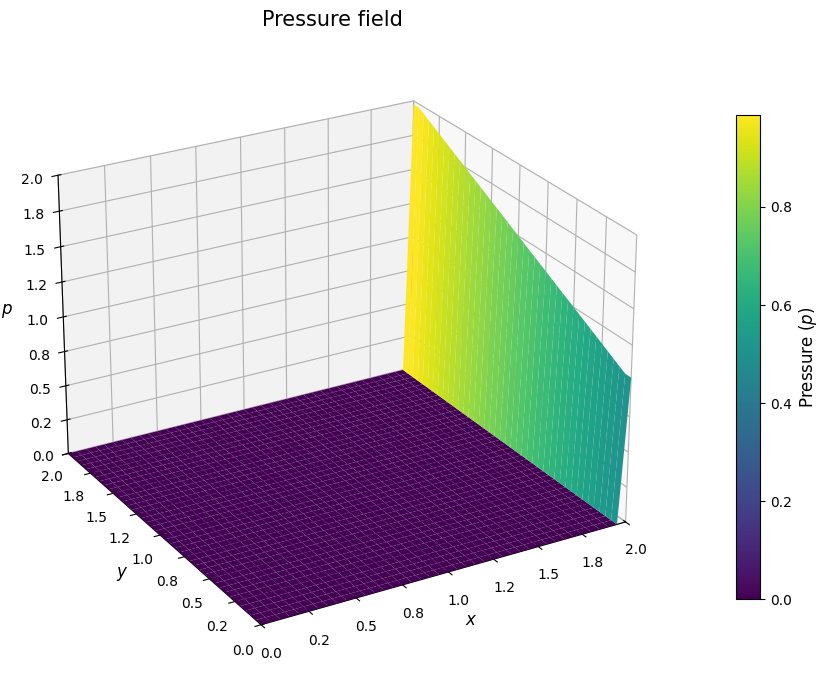

In [123]:
x_points = 41                                 # Number of x grid points
y_points = 41                                 # Number of y grid points
grid_length = 2                               # Lenght of the grid
dx = grid_length / (x_points - 1)             # Distance between adjacent x grid points
dy = grid_length / (x_points - 1)             # Distance between adjacent y grid points

p = np.zeros((y_points, x_points))
x = np.linspace(0, grid_length, x_points)
y = np.linspace(0, grid_length, y_points)

p[:, 0] = 0
p[:, -1] = 0.5*y + 1
p[0, :] = p[1, :]
p[-1, :] = p[-2, :]

plot_p_2d(x, y, p)

Now, solve Laplace's equation and plot the steady state

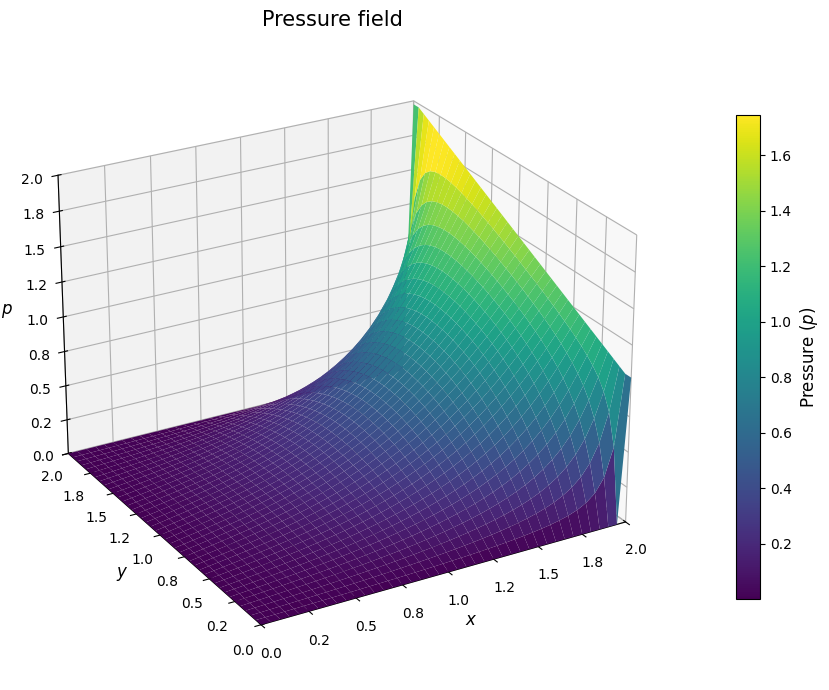

In [124]:
p = laplace_solver_2d(p, x, y, dx, dy, 1e-4)

plot_p_2d(x, y, p)